# WRF perturbations

This report shows comparisons between WRF output in non-perturbed control run with output in which the temperature or moisture have been perturbed around a given vertical level. The aim is to explore linear response functions as described in Kuang et al 2010.

In [3]:
import modules.wrf_perturbation as wp
import matplotlib.pyplot as plt
import numpy as np
import datetime

print("Report last updated at " + str(datetime.datetime.utcnow()) + ' UTC.')

Report last updated at 2020-07-20 02:00:28.449086 UTC.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Settings" data-toc-modified-id="Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Model-setup" data-toc-modified-id="Model-setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model setup</a></span><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Initial-state-and-model-settings" data-toc-modified-id="Initial-state-and-model-settings-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Initial state and model settings</a></span></li><li><span><a href="#Fixed-radiative-cooling-profile" data-toc-modified-id="Fixed-radiative-cooling-profile-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Fixed radiative cooling profile</a></span></li><li><span><a href="#Surface-flux-constraints" data-toc-modified-id="Surface-flux-constraints-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Surface flux constraints</a></span></li><li><span><a href="#Model-heights" data-toc-modified-id="Model-heights-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Model heights</a></span></li></ul></li><li><span><a href="#Perturbation-settings" data-toc-modified-id="Perturbation-settings-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Perturbation settings</a></span><ul class="toc-item"><li><span><a href="#Perturbed-model-level" data-toc-modified-id="Perturbed-model-level-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Perturbed model level</a></span></li></ul></li><li><span><a href="#Radiative-convective-equilibrium-(RCE)" data-toc-modified-id="Radiative-convective-equilibrium-(RCE)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Radiative-convective equilibrium (RCE)</a></span><ul class="toc-item"><li><span><a href="#Time-series-of-precipitable-water" data-toc-modified-id="Time-series-of-precipitable-water-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Time series of precipitable water</a></span></li><li><span><a href="#Outgoing-longwave-radiation-fields" data-toc-modified-id="Outgoing-longwave-radiation-fields-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Outgoing longwave radiation fields</a></span></li></ul></li><li><span><a href="#Profiles-by-time" data-toc-modified-id="Profiles-by-time-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Profiles by time</a></span><ul class="toc-item"><li><span><a href="#Horizontal-wind" data-toc-modified-id="Horizontal-wind-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Horizontal wind</a></span></li><li><span><a href="#Temperature" data-toc-modified-id="Temperature-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Temperature</a></span></li><li><span><a href="#Water-vapour-mixing-ratio" data-toc-modified-id="Water-vapour-mixing-ratio-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Water vapour mixing ratio</a></span></li><li><span><a href="#Relative-humidity" data-toc-modified-id="Relative-humidity-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Relative humidity</a></span></li></ul></li><li><span><a href="#Mean-temperature-and-humidity-profiles-over-RCE-periods" data-toc-modified-id="Mean-temperature-and-humidity-profiles-over-RCE-periods-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Mean temperature and humidity profiles over RCE periods</a></span></li><li><span><a href="#Perturbation-differences-in-averaged-RCE-profiles" data-toc-modified-id="Perturbation-differences-in-averaged-RCE-profiles-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Perturbation differences in averaged RCE profiles</a></span></li></ul></div>

## Settings

In [3]:
# Input directories with keys as dataset names.
basedir = '/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/'
inputs = {'Control':     basedir+'control/',        # Control run.
          'Control 2': basedir+'control/'} # Previous control w/ no nudging.
          #'Perturbed T': basedir+'perturb_T_850/'}  # Perturbed temperature @ 850 hPa.

# Figure settings.
plt.rcParams['figure.figsize'] = wp.FIGURE_SIZE  # Figure size for non-facetted plots.
plt.rcParams['font.size'] = 14                   # Font size for plots.

# Analysis settings. 
#control_start = '2000-05-24'        # Start date for control run averaging (inclusive).
#control_end   = '2000-05-31'        # End date for control run averaging (exclusive).
#perturb_start = '2000-08-01'        # Start date for perturbed run averaging (inclusive). 
#perturb_end   = '2000-08-08'        # End date for perturbed run averaging (exclusive).

control_start = '2000-03-10'
control_end = '2000-03-17'
perturb_start = '2000-03-10'
perturb_end = '2000-03-17'

plot_levels = [850, 500, 350, 200]  # Pressure levels to plot individually [hPa].

## Data preparation

The script `~/code/sh/extract_WRF_variables_parallel.sh` runs, in parallel, a python script that extracts variables of interest from `wrfout` files, optionally interpolates the 3D variables to vertical pressure levels, and takes spatial means across horizontal dimensions. The pressure levels to which the interpolation is done are from 1000 to 100 hPa in 10 hPa increments. These profiles of mean values per time are written to `wrfvar` files, which are then opened here.

In [4]:
wrfvars = wp.read_wrfvars(inputs=inputs)

## Model setup

### Description

The model is set to run using:

* a flat sea surface domain
* constant initial sea surface temperature (SST)
* zero coriolis effect
* a prescribed initial sounding/profile (see below)
* a fixed radiative cooling profile (see below)
* ideal evaporation as per Chua et al. (2019) (see below)
* no light nudging on U and V winds

### Initial state and model settings

The following function does some sanity checks on the `wrfinput` file that stores the initial model state. It shows basic settings and plots the initial profiles against the input sounding. The initial profiles are interpolated vertically in the `wrfinput` file using the initial sounding, and therefore should be almost identical to the sounding values by height.

In [5]:
wp.analyse_wrfinput(wrfinput_file=inputs['Control']+'wrfinput_d01',
                    sounding_file=inputs['Control']+'input_sounding')

FileNotFoundError: [Errno 2] No such file or directory: b'/g/data/up6/tr2908/em_quarter_ss/v4.1.4/original_1km/output/control/wrfinput_d01'

### Fixed radiative cooling profile

The radiative cooling profile is kept fixed in all runs following Herman and Kuang (2013). Between calls to the radiation driver and the surface driver, the value of the potential temperature tendancy due to the radiation scheme ($\theta_{\textrm{tend, rad}}$ in K s$^{-1}$) is set based on the pressure $p$ at each mass point. The value is $\theta_{tend,rad} = t/\Pi$, where $\Pi$ is the Exner function that converts temperature to potential temperature, and $t$ is a temperature tendency in K day$^{-1}$ set as follows:

 * $t = -1.5$ K day$^{-1}$ if $p \geq 200$ hPa.
 * $t = 0$ K day$^{-1}$ if $p \leq 100$ hPa.
 * $t$'s value varies linearly between -1.5 and 0 K day$^{-1}$ from 100 to 200 hPa.
 
Because $\Pi$ is not constant the values of potential temperature tendency vary slightly in time and space even though the cooling is constant, and the profiles of mean $\theta_{\textrm{tend,rad}}$ are curved. Here I plot $\theta_{\textrm{tend,rad}}$ which is called `RTHRATEN` in the WRF model. 

The point at which the tendency is a minimum is at 200 hPa in the raw files, but in the output interpolated to vertical levels it is at 210 hPa and the value for 200 hPa captures some of the larger values for $\geq$ 200 hPa. 

In [ ]:
wp.plot_radiative_cooling_profiles(dat=wrfvars)

The value of `RTHRATEN` is zero everywhere in the first model timestep since no tendency has been provided yet by the model. This first time step is excluded from the following plot which shows the tendancy due to the radiation scheme at various levels by time.

In [ ]:
wp.plot_radiative_cooling_by_level(dat=wrfvars, plot_levels=plot_levels)

### Surface flux constraints

We use ideal evaporation as per Chua et al. (2019), and a fixed value for surface wind (`surface_wind`) is used in the surface flux calculations. This means that:

* In the calculation of the upward moisture flux at the surface (`QFX` in kg m-2 s-1), the value for the exchange coefficient for moisture (`FLQC` in kg m-2 s-1) is replaced by `0.0010*surface_wind`.

* The upward heat flux at the surface (`HFX` in W m-2) is calculated as `CP*0.0010*surface_wind*(TSK(I)-T1D(I))` where `CP` is heat capacity at constant pressure for dry air in J kg-1 K-1, `TSK` is surface temperature in K and `T1D` is first-model-level temperature in K. The temperature difference used is the difference in temperature, not the difference in potential temperature that is otherwise used.

### Model heights


The model heights are prescribed so that the geopotential heights of the initial model state are  as close as possible to the height suggested for RCEMIP in Wing et al. (2018). 

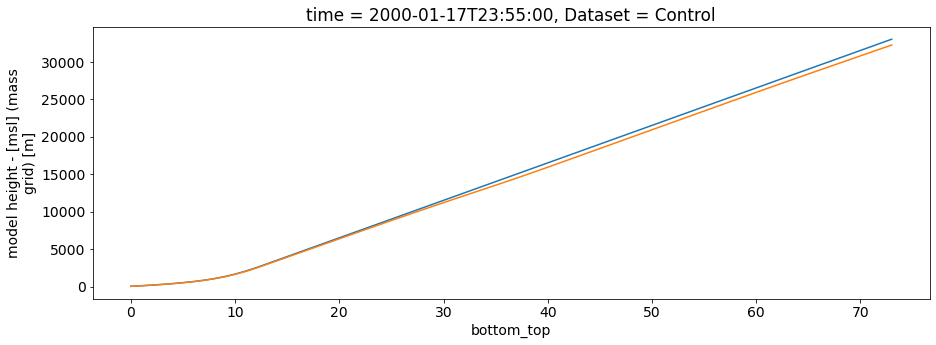

In [84]:
# Initial heights:
fig, ax = plt.subplots()

initial_heights = wrfvars.z.isel(time=0).sel(Dataset='Control')
initial_heights.plot(ax=ax)

rce_level_heights = wrfvars.z.isel(time=4895).sel(Dataset='Control')#.mean(['time'])
rce_level_heights.plot(ax=ax)

plt.show()

## Perturbation settings

### Perturbed model level

Perturbations are applied around a certain model level. Note that the WRF model uses $\sigma$-levels but calls them `eta levels`. Here are the settings used in the perturbed temperature run:

In [9]:
k_pert = wp.perturbation_details(wrfinput_file=inputs['Perturbed T']+'/wrfinput_d01',
                                 comparison_file=inputs['Control']+'/wrfinput_d01')

KeyError: 'Perturbed T'

The model pressure at the kth eta level will vary slightly in space and time. Here is the range of pressure values observed for this level in the perturbed run, and a plot of the minimum and maximum values.

In [10]:
wp.pressure_at_kth_eta_level(wrfvars=wrfvars.sel(time=slice(control_start, perturb_end)),
                             k_pert=k_pert, dataset='Perturbed T')

NameError: name 'k_pert' is not defined

## Radiative-convective equilibrium (RCE)

### Time series of precipitable water

To determine when the simulations have reached RCE, we look for stabilisation of the precipitable water (PW) field. Here is spatially-averaged PW by time for each simulation. The green highlighted region is the time span over which average profiles are calculated for the control run, the red region the time over which profiles are averaged for the perturbed runs.

In [ ]:
wrfvars.pw.plot(hue='Dataset')
plt.axvspan(xmin=control_start, xmax=control_end, alpha=0.3, color='green')
plt.axvspan(xmin=perturb_start, xmax=perturb_end, alpha=0.3, color='red')
plt.show()

### Outgoing longwave radiation fields

The outgoing longwave
radiation (OLR) field shows where convective cells are occurring. Here we plot cells at the end of each respective RCE period (the highlighted regions in the precipitable water plot).

In [ ]:
wp.plot_OLRs(inputs=inputs, patterns={'Control': 'wrfout*_'+control_end+'_*',
                                      'No nudging': 'wrfout*_'+perturb_end+'_*'})

## Profiles by time
### Horizontal wind

In [ ]:
wind = wp.get_wind(dat=wrfvars)
wind.plot(col='Dataset', x='time', figsize=wp.FIGURE_SIZE, cmap='plasma').set_titles('{value}')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
wrfvars.va.sel(level=plot_levels).plot(hue='Dataset', col='level', sharey=False, col_wrap=2, 
                                       figsize=[15,8]).set_titles('{value} hPa')
plt.savefig('new_winds.png', bbox_inches='tight')
plt.show()

### Temperature

In [ ]:
wrfvars.tk.plot(col='Dataset', x='time', figsize=wp.FIGURE_SIZE).set_titles('{value}')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
wrfvars.tk.sel(level=plot_levels).plot(hue='Dataset', col='level', col_wrap=2, sharey=False,
                                       figsize=[15,8]).set_titles('{value} hPa')
plt.show()

### Water vapour mixing ratio

In [ ]:
wrfvars.q.plot(col='Dataset', x='time', figsize=wp.FIGURE_SIZE).set_titles('{value}')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
wrfvars.q.sel(level=plot_levels).plot(hue='Dataset', col='level', col_wrap=2, sharey=False,
                                      figsize=[15,8]).set_titles('{value} hPa')
wp.rewrap_labels(plt.gcf().axes, length_y=25)
plt.show()

### Relative humidity

In [ ]:
wrfvars.rh.plot(y='level', col='Dataset', figsize=wp.FIGURE_SIZE).set_titles('{value}')
plt.show()

In [ ]:
wrfvars.rh.sel(level=plot_levels).plot(col='level', hue='Dataset', col_wrap=2, sharey=False,
                                       figsize=[15,8]).set_titles('{value} hPa')
wp.rewrap_labels(plt.gcf().axes, length_y=25)
plt.show()

## Mean temperature and humidity profiles over RCE periods

In [ ]:
wp.plot_profiles(wrfvars, control_start=control_start, control_end=control_end, 
                 other_start=perturb_start, other_end=perturb_end)

## Perturbation differences in averaged RCE profiles

Differences here are defined as `perturbed - control`. The red vertical line shows zero difference.

In [ ]:
wp.compare_profiles(wrfvars, control_start=control_start, control_end=control_end, 
                            other_start=perturb_start, other_end=perturb_end)